# **RANDOM CLASSIFICATION TO TEST MODEL ROBUSTNESS**

## Loading Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import warnings

from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid

In [2]:
cols = ['fileName','noun','fake','size','start','end']
indexer = pd.DataFrame(columns=cols)
df = pd.DataFrame(columns=range(768))
listNouns = ['article','beard','blood','company','death','gun','id','interview','passport']
#Load NOUN datasets
for noun in listNouns:
    arrF = np.load('BERTfiles/'+noun+'FAKE.npy')
    arrNF = np.load('BERTfiles/'+noun+'.npy')
    
    count=len(df)
    df = df.append(pd.DataFrame(arrF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'FAKE.npy',noun,True,arrF.shape[0],count,len(df)-1]],columns=cols)
    indexer = indexer.append(d_temp,ignore_index=True)
    
    count=len(df)
    df = df.append(pd.DataFrame(arrNF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'.npy',noun,False,arrNF.shape[0],count,len(df)-1]],columns=cols)
    indexer = indexer.append(d_temp,ignore_index=True)
    
    print("loaded for "+noun)

#-------------------------------------------------------------------------[FAKE]_NOUN_
#Define a dataframe that contains embeddings with FAKE
priv = ['beard','blood','company','death','gun']
indexer.insert(loc=3,column='privative',value=False)
for index, row in indexer.iterrows():
    if row['noun'] in priv:
        indexer.at[index,'privative']= True
        
priv_fakes_idx = indexer[(indexer.fake) & (indexer.privative)]
non_priv_fakes_idx = indexer[(indexer.fake==True) & (indexer.privative==False)]

fake_nouns = pd.DataFrame(columns=range(768))
for index, row in indexer[indexer['fake']].iterrows():
    fake_nouns=fake_nouns.append(df.loc[row['start']:row['end']])

#affine this dataframe : add a 'priv' column
if 'priv' in fake_nouns.columns:
    fake_nouns = fake_nouns.drop(columns=['priv'])
    
fake_nouns.insert(loc=768,column='priv',value=-1)
for index, row in priv_fakes_idx.iterrows():
    for i in range(row['start'],row['end']+1):
        fake_nouns.at[i,'priv']= 1

#add 'noun' column
if 'noun' in fake_nouns.columns:
    fake_nouns = fake_nouns.drop(columns=['noun'])
    
fake_nouns.insert(loc=768,column='noun',value='')
for index, row in indexer[indexer['fake']].iterrows():
    for i in range(row['start'],row['end']+1):
        fake_nouns.at[i,'noun']= row['noun']

targets_Fnouns = fake_nouns['priv']
nouns_Fnouns = fake_nouns['noun']
X_Fnouns = fake_nouns.drop(columns=['priv','noun'])

#---------------------------------------------------------------------[NOT FAKE]_NOUN_
not_fake_nouns = pd.DataFrame(columns=range(768))

priv_not_fakes_idx = indexer[(indexer.fake==False) & (indexer.privative)]

for index, row in indexer[indexer['fake']==False].iterrows():
    not_fake_nouns=not_fake_nouns.append(df.loc[row['start']:row['end']])

if 'priv' in not_fake_nouns.columns:
    not_fake_nouns = not_fake_nouns.drop(columns=['priv'])
    
not_fake_nouns.insert(loc=768,column='priv',value=-1)
for index, row in priv_not_fakes_idx.iterrows():
    for i in range(row['start'],row['end']+1):
        not_fake_nouns.at[i,'priv']= 1


if 'noun' in not_fake_nouns.columns:
    not_fake_nouns = not_fake_nouns.drop(columns=['noun'])
    
not_fake_nouns.insert(loc=768,column='noun',value='')
for index, row in indexer[indexer['fake']==False].iterrows():
    for i in range(row['start'],row['end']+1):
        not_fake_nouns.at[i,'noun']= row['noun']

targets_NFnouns = not_fake_nouns['priv']
nouns_NFnouns = not_fake_nouns['noun']
X_NFnouns = not_fake_nouns.drop(columns=['priv','noun'])

loaded for article
loaded for beard
loaded for blood
loaded for company
loaded for death
loaded for gun
loaded for id
loaded for interview
loaded for passport


In [3]:
cols = ['fileName','noun','size','start','end']
indexer_fakes = pd.DataFrame(columns=cols)
fakes_embd = pd.DataFrame(columns=range(768))

for noun in listNouns:
    arrF = np.load('BERTfiles/FAKE'+noun+'FAKE.npy')
    count=len(fakes_embd)
    fakes_embd = fakes_embd.append(pd.DataFrame(arrF),ignore_index=True)
    d_temp = pd.DataFrame(data=[[noun+'FAKE.npy',noun,arrF.shape[0],count,len(fakes_embd)-1]],columns=cols)
    indexer_fakes = indexer_fakes.append(d_temp,ignore_index=True)
    
    print("done for "+noun)
    
fakes_embd.index = X_Fnouns.index #re-indexing

if 'priv' in fakes_embd.columns:
    fakes_embd = fakes_embd.drop(columns=['priv'])
    
fakes_embd.insert(loc=768,column='priv',value=fake_nouns['priv'])

if 'noun' in fakes_embd.columns:
    fakes_embd = fakes_embd.drop(columns=['noun'])
    
fakes_embd.insert(loc=768,column='noun',value=fake_nouns['noun'])

targets_fakes = fakes_embd['priv']
nouns_fakes = fakes_embd['noun']
X_fakes = fakes_embd.drop(columns=['priv','noun'])

done for article
done for beard
done for blood
done for company
done for death
done for gun
done for id
done for interview
done for passport


In [4]:
# Here we don't need to extract a sample, we already computed only 10% on notfake NOUNS but to have same variable name, we will still define not_fake_samples
not_fake_samples = not_fake_nouns.loc[not_fake_nouns.sample(int(len(not_fake_nouns)/10)).index.sort_values()]
#The preservation of class (nouns) proportions is ensured by the size of the sample (around 8700 items)
targets_nfs = not_fake_samples['priv']
nouns_nfs = not_fake_samples['noun']
X_nfs = not_fake_samples.drop(columns=['priv','noun'])
not_fake_samples

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,noun,priv
83,0.755136,0.232570,-0.199666,0.463767,0.663022,-1.199443,-0.391038,1.085326,0.189961,-0.171142,...,0.036742,-0.650511,0.380231,0.306065,0.295004,-0.089623,-0.543798,0.043758,article,-1
90,0.887345,-0.478004,-0.144590,-0.250448,-0.047504,-0.477774,-0.738351,-0.564153,0.708437,0.314647,...,-0.291535,-0.844469,-0.240800,-0.276114,-1.273983,0.477902,-0.556078,0.115594,article,-1
97,0.785910,-0.589193,-0.171438,0.089936,0.080632,-0.688392,0.348680,0.697850,0.467649,0.030008,...,-0.166764,0.118167,0.318556,0.072831,-1.101906,0.572755,0.130434,-0.737753,article,-1
113,1.054923,-0.515205,-0.321260,-0.019554,-0.045904,-0.577336,0.157249,0.406565,-0.123129,0.027364,...,-0.213624,0.258772,-0.029288,-0.202340,-1.102368,0.642851,0.181463,0.055564,article,-1
129,0.891466,-0.236632,-0.196620,0.303198,0.364170,-0.904660,0.182874,1.168736,0.586862,-0.113370,...,-0.182495,-0.636457,-0.312408,0.102291,-0.447447,-0.076407,-0.334100,-0.009614,article,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90498,0.725322,0.232525,0.948554,-1.415909,0.653052,-1.147339,-0.128265,0.806909,0.552911,0.613849,...,0.691392,-0.843209,0.284835,-0.116793,-0.922084,-0.054046,-0.029775,0.352340,passport,-1
90527,1.351503,-0.488783,0.409440,-0.530064,1.327405,-1.461528,-0.696417,0.866018,0.317983,0.325492,...,0.486514,-0.729832,0.033889,0.462828,-0.963181,-0.879084,0.021213,-0.087972,passport,-1
90533,1.423911,-0.268469,0.598137,-0.930447,1.828776,-1.238091,-0.421552,1.061981,0.106228,0.286998,...,0.209283,-1.192030,-0.146765,-0.076595,-0.520497,-1.017229,0.187501,0.322867,passport,-1
90543,2.309781,-0.368508,0.441708,-0.857760,1.270062,-1.319232,-0.582670,1.095092,-0.002643,0.609746,...,0.650214,-0.756907,0.423892,-0.004851,-0.891437,-1.048233,0.277172,0.187378,passport,-1


In [5]:
nouns_NFnouns.value_counts()

article      12453
blood        11614
gun          11450
company      11333
death        10728
interview    10616
id            9059
passport      8975
beard         3744
Name: noun, dtype: int64

## Datasets storage reminder : 
* [fake] **NOUN** : fake_nouns ; indexer ; X_Fnouns ; targets_Fnouns ; nouns_Fnouns
* [not fake] **NOUN** : not_fake_nouns ; indexer ; X_NFnouns ; targets_NFnouns ; nouns_NFnouns
* **sampled** [not fake] **NOUN** : not_fake_samples ; - ; X_nfs ; targets_nfs ; nouns_nfs
* **FAKE** : fakes_embd ; indexer_fakes ; X_fakes ; targets_fakes ; nouns_fakes

## Random Sampling

In [6]:
def random_labeling(tolerance,df,debug=False,rng=None,out_list=False):
    delta = tolerance*2
    while delta > tolerance:
        if rng:
            rand_classes = {listNouns[k]:rng.integers(0,2) for k in range(9)}
        else:
            rand_classes = {listNouns[k]:np.random.randint(2) for k in range(9)}
        rand_targets = pd.Series(data=np.ones(len(df))*-1,index=df.index)
        for i, embd in df.iterrows():
            if rand_classes[embd['noun']]==1:
                rand_targets[i]=1
        delta = np.abs(rand_targets.sum())
    if debug:
        print('sampling delta : ', delta)
        print(rand_targets.value_counts())
    if out_list:
        return (rand_targets, rand_classes)
    else:
        return rand_targets

sampling delta :  3.0
-1.0    301
 1.0    298
dtype: int64


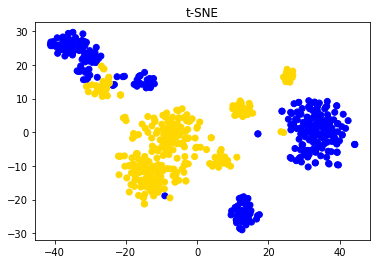

In [7]:
rand_targets = random_labeling(50,fakes_embd,True)
tsneX = TSNE(n_components=2, init='pca', random_state=0)
X_trans = tsneX.fit_transform(X_fakes).T

colors_classes={-1: 'blue', 1 : 'gold'}

plt.scatter(X_trans[0], X_trans[1], color=rand_targets.map(colors_classes))
plt.title("t-SNE")
plt.axis('tight')
plt.show()

## Functions to test robustness

### Banned Noun Classification (BNC)

In [7]:
def Accuracy_BannedNoun(classifier,Xtrain,Ttrain,Xbanned,Tbanned,preprocess=None,k=2,show_kbest=False):
    if preprocess=='pca':
        model = make_pipeline(Scaler(),PCA(n_components=0.975),classifier)
    else:
        model = classifier
    model.fit(Xtrain,Ttrain)
    y_train = model.predict(Xtrain)
    Tacc = np.sum(Ttrain == y_train)/len(Xtrain)
    y_banned = model.predict(Xbanned)
    Bacc = np.sum(Tbanned == y_banned)/len(Xbanned)
    return (Tacc,Bacc)

def BNC_accuracy(classifier,X,targets,nouns,preprocess=None,k=2,full_output=False,debug=False,show_kbest=False):
    if debug:
        print("\rTest {} : BNC  starting%                     ".format(debug), end="")
        sys.stdout.flush()
    Taccs = np.zeros(len(listNouns))
    Baccs = np.zeros(len(listNouns))
    
    for i,bannedW in enumerate(listNouns):
        if debug:
            print("\rTest {} : BNC for {} ; {}%             ".format(debug, bannedW, 100 * i // len(listNouns)), end="")
            sys.stdout.flush()
        Xtrain = X[nouns!=bannedW]
        Ttrain = targets[nouns!=bannedW]
        if preprocess=='kbest':
            select = SelectKBest(MIC,k).fit(Xtrain,Ttrain)
            scaler = Scaler()
            Xtrain = scaler.fit_transform(select.transform(Xtrain))
            if show_kbest:
                print("({})".format(np.where(select.get_support())[0]))
        Xbanned = X[nouns==bannedW]
        if preprocess == 'kbest':
            Xbanned = scaler.transform(select.transform(Xbanned))
        Tbanned = targets[nouns==bannedW]
        Tacc,Bacc = Accuracy_BannedNoun(classifier,Xtrain,Ttrain,Xbanned,Tbanned,preprocess,k,show_kbest)
        Taccs[i],Baccs[i] = Tacc, Bacc
    AvgTrain = np.mean(Taccs)
    AvgBanned = np.mean(Baccs)
    if full_output:
        return (Taccs,Baccs)
    else:
        return (AvgTrain,AvgBanned)

### Classical Train/Test split and classification

In [8]:
def classical_accuracy(classifier,X,targets,nouns,preprocess=None,k=2,out_model=False):
    #model selection
    if preprocess=='pca':
        model = make_pipeline(Scaler(),PCA(n_components=0.975),classifier)
    elif preprocess=='kbest':
        model = make_pipeline(SelectKBest(MIC,k),Scaler(),classifier)
    else:
        model = classifier
    #The training set should be balanced in term of repartition of nouns
    Xtrain,Xtest,Ttrain,Ttest =train_test_split(X, targets, test_size=0.25, random_state=0, stratify=nouns,shuffle=True)
    #model training and predictions
    model.fit(Xtrain,Ttrain)
    y_train = model.predict(Xtrain)
    y_test = model.predict(Xtest)
    #accuracies
    Train_acc = np.sum(Ttrain == y_train)/len(Xtrain)
    Test_acc = np.sum(Ttest == y_test)/len(Xtest)
    if out_model:
        return (Train_acc,Test_acc,model)
    else:
        return (Train_acc,Test_acc)

In [9]:
priv = ['beard','blood','company','death','gun']
non_priv = ['article','id','interview','passport']

In [10]:
delta_not_fake = np.sum(nouns_nfs.value_counts()[priv])-np.sum(nouns_nfs.value_counts()[non_priv])
delta_fake = np.abs(np.sum(nouns_fakes.value_counts()[priv])-np.sum(nouns_fakes.value_counts()[non_priv]))
print('% of original unbalancing : {}% in NOT FAKE ; {}% in FAKE'.format(delta_not_fake*100//len(nouns_nfs), delta_fake*100//len(nouns_fakes)))

% of original unbalancing : 9% in NOT FAKE ; 3% in FAKE


In [11]:
datasets = {'FAKES': [fakes_embd, X_fakes,targets_fakes, nouns_fakes],
            'fake NOUNS': [fake_nouns, X_Fnouns, targets_Fnouns, nouns_Fnouns],
            'not fake NOUNS': [not_fake_samples, X_nfs, targets_nfs, nouns_nfs]
           }
nb_tests = 8

In [13]:
def random_classif_process(classifier,clf_name,nb_tests,preprocess=None,k=2):
    print("============================================ {} =============================================".format(clf_name.upper()))
    for category in datasets.keys():
        print('--------------------------{}--------------------------'.format(category))
        embeddings,X,T,N = datasets[category]
        if preprocess=='tsne':
            tsne = TSNE(n_components=k)
            X = tsne.fit_transform(X)
        Taccs, Gaccs = np.zeros((2,nb_tests))
        BNC_Taccs, Baccs = np.zeros((2,nb_tests))
        for i in range(nb_tests):
            print("\rTest {} : random sampling            ".format(i+1), end="")
            sys.stdout.flush()
            rand_T = random_labeling(int(len(embeddings)*0.09),embeddings) #we have a tolerance of 9% the size of the dataset, since it is the difference maximum we observed in the original class repartition
            print("\rTest {} : random classif              ".format(i+1), end="")
            sys.stdout.flush()
            Taccs[i], Gaccs[i] = classical_accuracy(classifier,X,rand_T,N,preprocess=preprocess,k=k)
            BNC_Taccs[i], Baccs[i] = BNC_accuracy(classifier,X,rand_T,N,preprocess=preprocess,k=k,debug=i+1)
        print('\rAverage train accuracy : {}%   ( {}  )'.format(np.mean(Taccs).round(4)*100,np.std(Taccs).round(4)*100))
        print('Average test accuracy : {}%   ( {}  )'.format(np.mean(Gaccs).round(4)*100,np.std(Gaccs).round(4)*100))
        print('\rAverage BNC train accuracy : {}%   ( {}  )'.format(np.mean(BNC_Taccs).round(4)*100,np.std(BNC_Taccs).round(4)*100))
        print('Average BNC test accuracy : {}%   ( {}  )'.format(np.mean(Baccs).round(4)*100,np.std(Baccs).round(4)*100))

In [14]:
def partition(n):
    buffer = []
    if n==1:
        return [[0],[1]]
    sub_list=partition(n-1)
    for part in sub_list:
        buffer.append([0]+part.copy())
        buffer.append([1]+part.copy())
    return buffer


## Visualization of a random classification

We will use FAKE embeddings

In [535]:
# # Looking for a random key that output the original separation
# privativity_dict = {'article': 0, 'beard': 1, 'blood': 1, 'company': 1, 'death': 1, 'gun': 1, 'id': 0, 'interview': 0, 'passport': 0}
# non_privativity_dict = {n:0**privativity_dict[n] for n in privativity_dict}

# i=0
# rng = np.random.default_rng(i)
# rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,rng=rng,out_list=True)

# while rand_dict != privativity_dict and rand_dict != non_privativity_dict:
#     i+=1
#     rng = np.random.default_rng(i)
#     rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,rng=rng,out_list=True)
# print(i)

In [15]:
warnings.filterwarnings('ignore') #ignore FutureWarnings

{'article': 0, 'beard': 0, 'blood': 0, 'company': 0, 'death': 1, 'gun': 0, 'id': 1, 'interview': 1, 'passport': 1}
Test 1 : BNC for passport ; 88%              

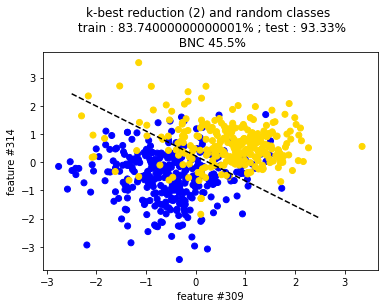

In [35]:
rng = np.random.default_rng(42) #set 26 to get original class division

#Choose if you want a controlled rng or not
#rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,rng=rng,out_list=True)
rand_T, rand_dict = random_labeling(int(len(fakes_embd)*0.09),fakes_embd,out_list=True)

print(rand_dict)

Tacc, Gacc, model = classical_accuracy(LinearSVC(max_iter=100000),X_fakes,rand_T,nouns_fakes,preprocess='kbest',k=2,out_model=True)
_, Loc_Bacc = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,rand_T,nouns_fakes, preprocess='kbest',k=2,debug=1)


X_fakes_trans = model[1].transform(model[0].transform(X_fakes)).T
axes_nb = np.where(model[0].get_support())[0]

colors_classes={-1: 'blue', 1 : 'gold'}

w = model[2].coef_[0]
i = model[2].intercept_[0]
x1 = np.linspace(-2.5,2.5,10)
a = -w[0]/w[1]
x2 = a * x1 - i/w[1]
colors_classes={-1: 'blue', 1 : 'gold'}

plt.scatter(X_fakes_trans[0], X_fakes_trans[1], color=rand_T.map(colors_classes))
plt.plot(x1,x2,'k--',label='Separation line')
plt.title("k-best reduction (2) and random classes \n train : {}% ; test : {}%\n BNC {}%".format(Tacc.round(4)*100, Gacc.round(4)*100,Loc_Bacc.round(4)*100))
plt.axis('tight')
plt.xlabel('feature #' + str(axes_nb[0]))
plt.ylabel('feature #' + str(axes_nb[1]))
plt.show()

Test 1 : BNC for passport ; 88%              

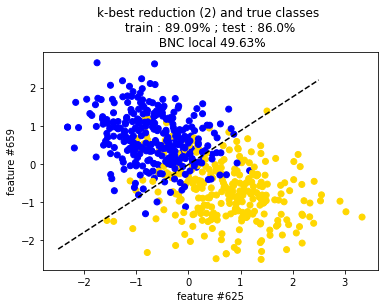

In [20]:
Tacc, Gacc, model = classical_accuracy(LinearSVC(max_iter=100000),X_fakes,targets_fakes,nouns_fakes,preprocess='kbest',k=2,out_model=True)
_, Loc_Bacc = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,targets_fakes,nouns_fakes, preprocess='kbest',k=2,debug=1)


X_fakes_trans = model[1].transform(model[0].transform(X_fakes)).T
axes_nb = np.where(model[0].get_support())[0]

colors_classes={-1: 'blue', 1 : 'gold'}

w = model[2].coef_[0]
i = model[2].intercept_[0]
x1 = np.linspace(-2.5,2.5,10)
a = -w[0]/w[1]
x2 = a * x1 - i/w[1]
colors_classes={-1: 'blue', 1 : 'gold'}

plt.scatter(X_fakes_trans[0], X_fakes_trans[1], color=targets_fakes.map(colors_classes))
plt.plot(x1,x2,'k--',label='Separation line')
plt.title("k-best reduction (2) and true classes \n train : {}% ; test : {}% \n BNC {}%".format(Tacc.round(4)*100, Gacc.round(4)*100,Loc_Bacc.round(4)*100,))
plt.axis('tight')
plt.xlabel('feature #' + str(axes_nb[0]))
plt.ylabel('feature #' + str(axes_nb[1]))
plt.show()

In [36]:
BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,targets_fakes,nouns_fakes, preprocess='kbest',k=10,debug=2,show_kbest=True)

Test 2 : BNC for article ; 0%               ([151 155 196 213 368 372 567 625 659 676])
Test 2 : BNC for beard ; 11%             ([151 155 217 371 372 560 567 625 659 761])
Test 2 : BNC for blood ; 22%             ([ 46 155 196 211 379 411 461 514 659 676])
Test 2 : BNC for company ; 33%             ([ 57 151 155 196 328 372 410 597 625 659])
Test 2 : BNC for death ; 44%             ([ 57 151 155 328 372 439 567 625 645 659])
Test 2 : BNC for gun ; 55%             ([ 57 151 155 217 328 372 567 597 625 659])
Test 2 : BNC for id ; 66%             ([155 217 254 378 460 589 625 657 659 761])
Test 2 : BNC for interview ; 77%             ([ 57 151 155 217 328 372 410 567 625 659])
Test 2 : BNC for passport ; 88%             ([151 155 217 328 371 372 460 567 625 659])


(0.9664954508307457, 0.7370792962792838)

In [497]:
selector = SelectKBest(MIC,2)
X_trans = Scaler().fit_transform(selector.fit_transform(X_fakes,rand_T))
print("\r{}".format(np.where(selector.get_support())[0]))
BNC_accuracy(classifier,X_trans,rand_T,nouns_fakes)

[676 985]


(0.8607260725479077, 0.7250925658136687)

In [ ]:
warnings.filterwarnings('default')

## Testing all random partitions with 2-KBEST (Linear SVM)

In [16]:
warnings.filterwarnings('ignore')

In [17]:
combinaisons = partition(9)

counts = nouns_fakes.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<int(len(fakes_embd)*0.09):
        valid_parts.append(part)
origin_ind_fakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_fakes)            
len(valid_parts)

original index :  9


88

In [18]:
# As expected, all valid partitions have also their symetric that is valid and in the reverse order.
pairs = 0
for i in range(len(valid_parts)//2):
    if valid_parts[i]==list((np.array(valid_parts[-i-1])-1)*-1):
        pairs+=1
pairs

44

In [19]:
parts_to_test = valid_parts[:len(valid_parts)//2]
FAKES_classic_scores = np.empty(len(parts_to_test))
FAKES_BNC_scores = np.empty(len(parts_to_test))
FNOUNS_classic_scores = np.empty(len(parts_to_test))
FNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(fakes_embd))*-1,index=fakes_embd.index)
    for i, embd in fakes_embd.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,FAKES_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=2)
    _,FAKES_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=2,debug=ind+1)
    _,FNOUNS_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_Fnouns,part_targets,nouns_Fnouns ,preprocess='kbest',k=2)
    _,FNOUNS_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_Fnouns,part_targets,nouns_Fnouns,preprocess='kbest',k=2,debug=ind+1)


Test 44 : BNC for passport ; 88%              

In [20]:
np.max(FAKES_BNC_scores)

0.5951667048397602

In [21]:
high_s_fakes = FAKES_BNC_scores[FAKES_BNC_scores>0.31]
highest_p_fakes = np.flip(np.argsort(FAKES_BNC_scores))[:len(high_s_fakes)]
for ind in highest_p_fakes:
    if ind == origin_ind_fakes:
        print(FAKES_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FAKES_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.5952 [1, 1, 0, 0, 1, 1, 1, 1, 0] 42
0.5675 [1, 1, 1, 0, 0, 0, 0, 1, 0] 20
0.5671 [1, 1, 0, 0, 1, 0, 1, 1, 0] 33
0.5611 [1, 0, 1, 0, 0, 1, 0, 1, 0] 24
0.5535 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.5265 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12
0.518 [0, 0, 1, 1, 1, 0, 1, 0, 0] 14
0.5111 [1, 0, 0, 1, 1, 1, 1, 1, 0] 43
0.5101 [0, 1, 1, 0, 1, 1, 0, 1, 0] 26
0.5091 [1, 1, 1, 0, 1, 0, 0, 0, 0] 3
0.5087 [1, 1, 0, 1, 1, 0, 1, 0, 0] 13
0.5034 [1, 1, 0, 0, 0, 1, 1, 1, 0] 37
0.5026 [0, 1, 1, 1, 1, 0, 0, 1, 0] 23
0.4963 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.4884 [1, 0, 0, 1, 1, 0, 1, 1, 0] 35
0.4764 [1, 1, 0, 1, 0, 1, 1, 1, 0] 39
0.4683 [0, 1, 1, 0, 0, 1, 1, 0, 0] 15
0.4579 [0, 0, 1, 1, 1, 1, 0, 1, 0] 27
0.455 [1, 1, 1, 1, 0, 1, 0, 0, 0] 7
0.4539 [1, 1, 0, 1, 0, 0, 1, 1, 0] 31
0.4494 [1, 0, 1, 0, 1, 0, 0, 0, 0] 2
0.4481 [1, 0, 1, 1, 0, 0, 0, 1, 0] 21
0.4384 [1, 1, 1, 1, 0, 0, 0, 0, 0] 1
0.4211 [1, 1, 0, 1, 1, 1, 1, 0, 0] 19
0.4192 [1, 0, 1, 0, 1, 0, 0, 1, 0] 22
0.4162 [0, 0, 1, 0, 1, 1, 1,

In [22]:
high_s_fnouns = FNOUNS_BNC_scores[FNOUNS_BNC_scores>0.31]
highest_p_fnouns = np.flip(np.argsort(FNOUNS_BNC_scores))[:len(high_s_fnouns)]
for ind in highest_p_fnouns:
    if ind == origin_ind_fakes:
        print(FNOUNS_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.823 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12
0.7402 [1, 1, 1, 1, 0, 1, 0, 0, 0] 7
0.726 [0, 1, 1, 0, 1, 1, 0, 1, 0] 26
0.7223 [0, 0, 1, 0, 0, 1, 1, 1, 0] 38
0.7168 [1, 0, 1, 0, 1, 0, 0, 1, 0] 22
0.6794 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.6593 [0, 0, 1, 1, 1, 0, 1, 0, 0] 14
0.6578 [1, 0, 1, 1, 0, 0, 0, 1, 0] 21
0.6402 [0, 1, 1, 0, 0, 1, 1, 0, 0] 15
0.6111 [1, 1, 1, 0, 1, 0, 0, 0, 0] 3
0.5767 [0, 0, 1, 1, 0, 1, 1, 1, 0] 40
0.5751 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.5618 [1, 1, 0, 0, 1, 1, 1, 1, 0] 42
0.5606 [1, 1, 0, 0, 0, 1, 1, 1, 0] 37
0.5306 [1, 1, 1, 0, 0, 0, 0, 1, 0] 20
0.4698 [1, 0, 1, 0, 1, 0, 0, 0, 0] 2
0.4625 [1, 0, 1, 1, 0, 1, 0, 0, 0] 6
0.4606 [0, 0, 1, 1, 0, 1, 1, 0, 0] 16
0.4547 [0, 1, 1, 1, 1, 0, 0, 1, 0] 23
0.4325 [0, 1, 1, 0, 0, 0, 1, 0, 0] 10
0.4207 [1, 1, 0, 0, 1, 0, 1, 1, 0] 33
0.4176 [1, 0, 0, 1, 1, 0, 1, 1, 0] 35
0.4035 [1, 0, 1, 1, 1, 0, 0, 0, 0] 4
0.3945 [1, 0, 1, 0, 0, 1, 0, 1, 0] 24
0.3893 [0, 0, 1, 0, 0, 0, 1, 1, 0] 29
0.3872 [0, 1, 1, 1, 1, 1, 0, 

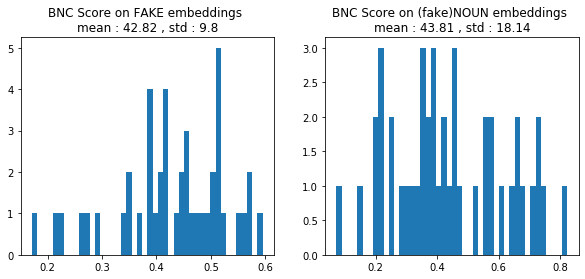

In [23]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(FAKES_BNC_scores,bins=44,density=False)
ax[1].hist(FNOUNS_BNC_scores,bins=44,density=False)
ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
plt.show()

In [24]:
np.round((np.mean(FAKES_BNC_scores),np.std(FAKES_BNC_scores)),4)

array([0.4282, 0.0985])

In [25]:
np.round((np.mean(FNOUNS_BNC_scores),np.std(FNOUNS_BNC_scores)),4)

array([0.4381, 0.1814])

In [26]:
counts = nouns_nfs.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<=int(max(len(not_fake_samples)*0.09,targets_nfs.sum())):
        valid_parts.append(part)

origin_ind_notfakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_notfakes)

print('nb of valid partitions : ',len(valid_parts))



original index :  5
nb of valid partitions :  126


In [27]:
parts_to_test = valid_parts[:len(valid_parts)//2]
NFNOUNS_classic_scores = np.empty(len(parts_to_test))
NFNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(not_fake_samples))*-1,index=not_fake_samples.index)
    for i, embd in not_fake_samples.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,NFNOUNS_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_nfs,part_targets,nouns_nfs ,preprocess='kbest',k=2)
    _,NFNOUNS_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_nfs,part_targets,nouns_nfs,preprocess='kbest',k=2,debug=ind+1)


Test 63 : BNC for passport ; 88%              

In [28]:
np.max(NFNOUNS_BNC_scores)

0.7983978503227339

In [30]:
high_s_nfnouns = NFNOUNS_BNC_scores[NFNOUNS_BNC_scores>np.mean(NFNOUNS_BNC_scores)]
highest_p_nfnouns = np.flip(np.argsort(NFNOUNS_BNC_scores))[:len(high_s_nfnouns)]
for ind in highest_p_nfnouns:
    if ind == origin_ind_notfakes:
        print(NFNOUNS_BNC_scores[origin_ind_notfakes].round(4) , valid_parts[origin_ind_notfakes], ' baseline (original partition)')
    else:
        print(NFNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.7984 [0, 1, 0, 1, 1, 1, 0, 1, 0] 42
0.7544 [0, 1, 1, 1, 0, 1, 0, 1, 0] 36
0.7165 [0, 1, 1, 0, 1, 1, 0, 1, 0] 40
0.7 [0, 1, 1, 1, 0, 0, 1, 1, 0] 48
0.686 [1, 0, 0, 0, 1, 0, 1, 1, 0] 49
0.6435 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.6356 [1, 0, 0, 1, 0, 0, 1, 1, 0] 45
0.6274 [0, 1, 0, 0, 1, 1, 1, 1, 0] 62
0.6238 [1, 0, 0, 1, 0, 1, 1, 0, 0] 16
0.6226 [0, 0, 0, 0, 1, 1, 1, 1, 0] 61
0.6168 [0, 0, 0, 1, 1, 0, 1, 1, 0] 53
0.6136 [1, 0, 0, 1, 1, 0, 1, 0, 0] 10
0.6017 [0, 0, 1, 1, 1, 1, 0, 0, 0] 4
0.598 [1, 0, 1, 1, 0, 1, 0, 0, 0] 1
0.5925 [0, 0, 1, 1, 0, 1, 0, 1, 0] 35
0.5608 [1, 0, 1, 0, 0, 0, 1, 1, 0] 43
0.5591 [1, 0, 1, 0, 1, 0, 0, 1, 0] 27
0.5555 [1, 0, 0, 1, 1, 0, 0, 1, 0] 29
0.555 [1, 1, 0, 0, 0, 1, 1, 1, 0] 56
0.5429 [1, 0, 1, 1, 0, 0, 0, 1, 0] 26
0.5414 [0, 0, 0, 1, 1, 1, 0, 1, 0] 41
0.5368 [1, 1, 0, 0, 1, 1, 1, 0, 0] 21
0.5221 [0, 0, 1, 1, 1, 0, 0, 1, 0] 31
0.5205 [1, 1, 0, 1, 1, 0, 0, 1, 0] 30
0.5188 [1, 1, 1, 1, 0, 0, 1, 0, 0] 7
0.4976 [1, 1, 0, 0, 1, 1, 0, 1,

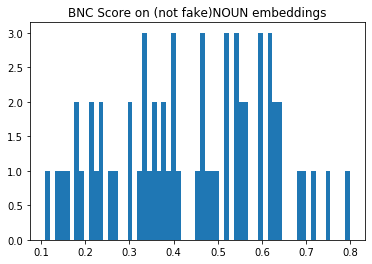

In [31]:
plt.hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False)
plt.title('BNC Score on (not fake)NOUN embeddings')
plt.show()

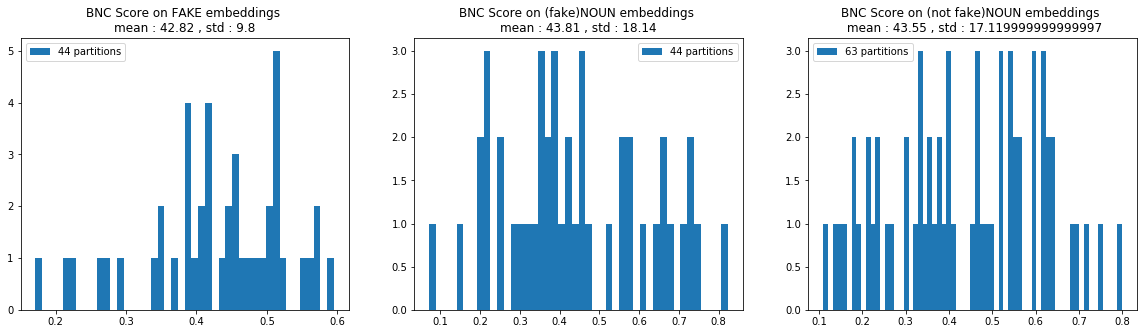

In [33]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist(FAKES_BNC_scores,bins=len(FAKES_BNC_scores),density=False, label='{} partitions'.format(len(FAKES_BNC_scores)))
ax[1].hist(FNOUNS_BNC_scores,bins=len(FNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(FNOUNS_BNC_scores)))
ax[2].hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(NFNOUNS_BNC_scores)))

ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
ax[2].set_title('BNC Score on (not fake)NOUN embeddings \n mean : {} , std : {}'.format(np.mean(NFNOUNS_BNC_scores).round(4)*100,np.std(NFNOUNS_BNC_scores).round(4)*100))

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('random_scores_BERT_kbest.png',dpi=300)
plt.show()

In [ ]:
warnings.filterwarnings('default')

## Testing all random partitions with 10-KBEST (LINEAR SVM)

In [17]:
warnings.filterwarnings('ignore')

In [37]:
combinaisons = partition(9)

counts = nouns_fakes.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<int(len(fakes_embd)*0.09):
        valid_parts.append(part)
origin_ind_fakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_fakes)            
len(valid_parts)

original index :  9


88

In [38]:
# As expected, all valid partitions have also their symetric that is valid and in the reverse order.
pairs = 0
for i in range(len(valid_parts)//2):
    if valid_parts[i]==list((np.array(valid_parts[-i-1])-1)*-1):
        pairs+=1
pairs

44

In [39]:
parts_to_test = valid_parts[:len(valid_parts)//2]
FAKES_classic_scores = np.empty(len(parts_to_test))
FAKES_BNC_scores = np.empty(len(parts_to_test))
FNOUNS_classic_scores = np.empty(len(parts_to_test))
FNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(fakes_embd))*-1,index=fakes_embd.index)
    for i, embd in fakes_embd.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,FAKES_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=10)
    _,FAKES_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=10,debug=ind+1)
    _,FNOUNS_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_Fnouns,part_targets,nouns_Fnouns ,preprocess='kbest',k=10)
    _,FNOUNS_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_Fnouns,part_targets,nouns_Fnouns,preprocess='kbest',k=10,debug=ind+1)


Test 44 : BNC for passport ; 88%              

In [40]:
np.max(FAKES_BNC_scores)

0.7370792962792838

In [41]:
high_s_fakes = FAKES_BNC_scores[FAKES_BNC_scores>np.mean(FAKES_BNC_scores)]
highest_p_fakes = np.flip(np.argsort(FAKES_BNC_scores))[:len(high_s_fakes)]
for ind in highest_p_fakes:
    if ind == origin_ind_fakes:
        print(FAKES_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FAKES_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.7371 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.6437 [1, 0, 1, 1, 0, 1, 0, 1, 0] 25
0.6287 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.6238 [0, 1, 1, 0, 1, 1, 0, 1, 0] 26
0.6151 [1, 1, 0, 0, 1, 0, 1, 1, 0] 33
0.6048 [1, 0, 0, 1, 1, 0, 1, 1, 0] 35
0.5859 [1, 1, 1, 0, 0, 0, 0, 1, 0] 20
0.581 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12
0.5725 [0, 1, 1, 0, 0, 1, 1, 0, 0] 15
0.5593 [1, 0, 1, 0, 1, 0, 0, 0, 0] 2
0.5562 [0, 1, 1, 1, 1, 1, 0, 1, 0] 28
0.5443 [1, 0, 1, 0, 1, 0, 0, 1, 0] 22
0.5311 [1, 0, 1, 1, 0, 0, 0, 1, 0] 21
0.5152 [0, 1, 1, 1, 1, 0, 0, 1, 0] 23
0.4977 [0, 1, 1, 0, 0, 0, 1, 0, 0] 10
0.4934 [1, 0, 0, 1, 1, 1, 1, 1, 0] 43
0.4899 [1, 1, 0, 0, 1, 1, 1, 1, 0] 42
0.4808 [1, 1, 1, 0, 1, 0, 0, 0, 0] 3
0.4685 [1, 0, 1, 0, 0, 1, 0, 1, 0] 24
0.459 [1, 0, 1, 1, 0, 1, 0, 0, 0] 6
0.4555 [1, 1, 1, 1, 0, 1, 0, 0, 0] 7
0.4472 [1, 0, 1, 1, 1, 0, 0, 0, 0] 4


In [42]:
high_s_fnouns = FNOUNS_BNC_scores[FNOUNS_BNC_scores>np.mean(FNOUNS_BNC_scores)]
highest_p_fnouns = np.flip(np.argsort(FNOUNS_BNC_scores))[:len(high_s_fnouns)]
for ind in highest_p_fnouns:
    if ind == origin_ind_fakes:
        print(FNOUNS_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.9583 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.753 [1, 1, 0, 0, 0, 1, 1, 1, 0] 37
0.6865 [1, 0, 1, 0, 1, 0, 0, 1, 0] 22
0.6386 [1, 1, 0, 0, 1, 0, 1, 1, 0] 33
0.6252 [1, 1, 0, 1, 0, 1, 1, 1, 0] 39
0.6228 [1, 0, 1, 0, 1, 0, 0, 0, 0] 2
0.6176 [1, 1, 1, 0, 1, 0, 0, 0, 0] 3
0.6025 [0, 0, 1, 1, 1, 0, 1, 0, 0] 14
0.5945 [0, 0, 1, 0, 0, 0, 1, 1, 0] 29
0.5877 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.5837 [0, 0, 1, 0, 0, 1, 1, 1, 0] 38
0.5809 [1, 0, 1, 1, 0, 0, 0, 1, 0] 21
0.5621 [0, 1, 1, 0, 0, 0, 1, 0, 0] 10
0.5619 [1, 1, 0, 0, 1, 1, 1, 1, 0] 42
0.5498 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12
0.5 [0, 1, 1, 0, 1, 1, 0, 1, 0] 26
0.4955 [1, 1, 1, 1, 0, 1, 0, 0, 0] 7
0.4891 [1, 1, 1, 0, 0, 0, 0, 1, 0] 20
0.483 [0, 0, 1, 0, 1, 1, 1, 0, 0] 18
0.4808 [1, 0, 1, 1, 0, 1, 0, 1, 0] 25
0.4782 [1, 0, 0, 1, 1, 1, 1, 1, 0] 43
0.4638 [1, 0, 1, 1, 1, 0, 0, 0, 0] 4


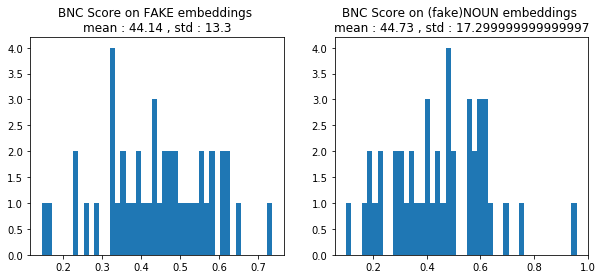

In [43]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(FAKES_BNC_scores,bins=44,density=False)
ax[1].hist(FNOUNS_BNC_scores,bins=44,density=False)
ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
plt.show()

In [44]:
np.round((np.mean(FAKES_BNC_scores),np.std(FAKES_BNC_scores)),4)

array([0.4414, 0.1332])

In [45]:
np.round((np.mean(FNOUNS_BNC_scores),np.std(FNOUNS_BNC_scores)),4)

array([0.4473, 0.173 ])

In [46]:
counts = nouns_nfs.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<=int(max(len(not_fake_samples)*0.09,targets_nfs.sum())):
        valid_parts.append(part)

origin_ind_notfakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_notfakes)

print('nb of valid partitions : ',len(valid_parts))



original index :  5
nb of valid partitions :  124


In [47]:
parts_to_test = valid_parts[:len(valid_parts)//2]
NFNOUNS_classic_scores = np.empty(len(parts_to_test))
NFNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(not_fake_samples))*-1,index=not_fake_samples.index)
    for i, embd in not_fake_samples.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,NFNOUNS_classic_scores[ind] = classical_accuracy(LinearSVC(max_iter=100000),X_nfs,part_targets,nouns_nfs ,preprocess='kbest',k=10)
    _,NFNOUNS_BNC_scores[ind] = BNC_accuracy(LinearSVC(max_iter=100000),X_nfs,part_targets,nouns_nfs,preprocess='kbest',k=10,debug=ind+1)


Test 62 : BNC for passport ; 88%              

In [48]:
np.max(NFNOUNS_BNC_scores)

0.8885864740525957

In [49]:
high_s_nfnouns = NFNOUNS_BNC_scores[NFNOUNS_BNC_scores>np.mean(NFNOUNS_BNC_scores)]
highest_p_nfnouns = np.flip(np.argsort(NFNOUNS_BNC_scores))[:len(high_s_nfnouns)]
for ind in highest_p_nfnouns:
    if ind == origin_ind_notfakes:
        print(NFNOUNS_BNC_scores[origin_ind_notfakes].round(4) , valid_parts[origin_ind_notfakes], ' baseline (original partition)')
    else:
        print(NFNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.8886 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.8529 [1, 0, 0, 1, 0, 0, 1, 1, 0] 44
0.7527 [0, 0, 1, 1, 1, 1, 0, 0, 0] 4
0.7464 [1, 1, 0, 1, 1, 0, 0, 1, 0] 30
0.7075 [1, 0, 0, 1, 0, 1, 0, 1, 0] 34
0.6815 [0, 0, 0, 1, 1, 1, 0, 1, 0] 40
0.6725 [0, 0, 1, 1, 0, 1, 0, 1, 0] 35
0.6541 [1, 1, 0, 1, 0, 0, 1, 1, 0] 45
0.636 [1, 0, 1, 0, 1, 0, 0, 1, 0] 28
0.6122 [0, 1, 0, 1, 1, 1, 0, 1, 0] 41
0.6024 [0, 0, 0, 1, 1, 0, 1, 1, 0] 52
0.5926 [1, 0, 0, 1, 1, 0, 0, 1, 0] 29
0.5697 [0, 0, 1, 1, 1, 0, 0, 1, 0] 31
0.5418 [0, 1, 1, 1, 0, 1, 0, 1, 0] 36
0.5303 [0, 0, 0, 0, 1, 1, 1, 1, 0] 60
0.5291 [0, 1, 0, 1, 1, 0, 1, 1, 0] 53
0.5177 [1, 1, 0, 0, 0, 1, 1, 1, 0] 55
0.5152 [1, 0, 0, 0, 1, 1, 0, 1, 0] 37
0.5119 [0, 1, 0, 1, 0, 1, 1, 1, 0] 59
0.5038 [1, 0, 1, 1, 0, 1, 0, 0, 0] 1
0.5035 [1, 0, 1, 0, 0, 1, 0, 1, 0] 33
0.4809 [0, 1, 1, 0, 1, 1, 0, 1, 0] 39
0.4791 [1, 1, 1, 0, 0, 0, 1, 1, 0] 43
0.4714 [0, 0, 1, 1, 1, 0, 1, 0, 0] 12
0.4707 [1, 0, 1, 0, 1, 1, 0, 0, 0] 2
0.4691 [1, 0, 0, 0, 1, 0, 

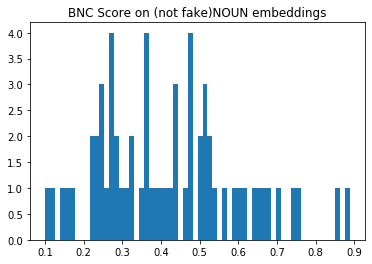

In [50]:
plt.hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False)
plt.title('BNC Score on (not fake)NOUN embeddings')
plt.show()

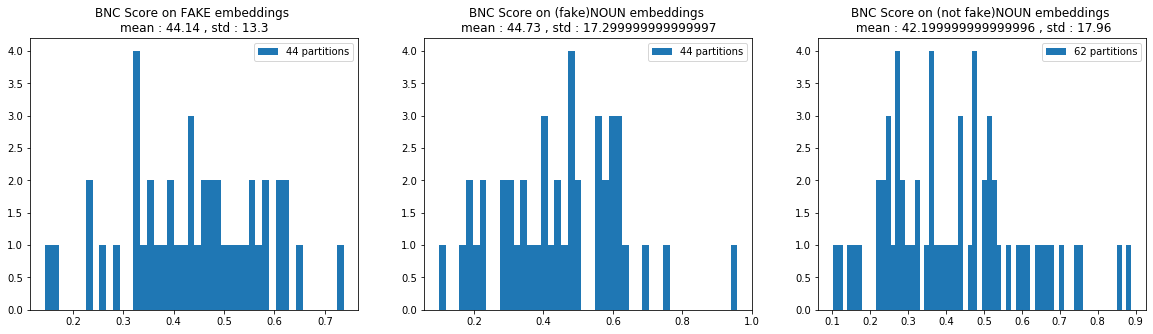

In [51]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist(FAKES_BNC_scores,bins=len(FAKES_BNC_scores),density=False, label='{} partitions'.format(len(FAKES_BNC_scores)))
ax[1].hist(FNOUNS_BNC_scores,bins=len(FNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(FNOUNS_BNC_scores)))
ax[2].hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(NFNOUNS_BNC_scores)))

ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
ax[2].set_title('BNC Score on (not fake)NOUN embeddings \n mean : {} , std : {}'.format(np.mean(NFNOUNS_BNC_scores).round(4)*100,np.std(NFNOUNS_BNC_scores).round(4)*100))

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('random_scores_BERT_kbest_10.png',dpi=300)
plt.show()

In [ ]:
warnings.filterwarnings('default')

## Testing all random partitions with 10-KBEST (Nearest Neighbors)

In [12]:
warnings.filterwarnings('ignore')

In [15]:
combinaisons = partition(9)

counts = nouns_fakes.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<int(len(fakes_embd)*0.09):
        valid_parts.append(part)
origin_ind_fakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_fakes)            
len(valid_parts)

original index :  9


88

In [16]:
# As expected, all valid partitions have also their symetric that is valid and in the reverse order.
pairs = 0
for i in range(len(valid_parts)//2):
    if valid_parts[i]==list((np.array(valid_parts[-i-1])-1)*-1):
        pairs+=1
pairs

44

In [17]:
parts_to_test = valid_parts[:len(valid_parts)//2]
FAKES_classic_scores = np.empty(len(parts_to_test))
FAKES_BNC_scores = np.empty(len(parts_to_test))
FNOUNS_classic_scores = np.empty(len(parts_to_test))
FNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(fakes_embd))*-1,index=fakes_embd.index)
    for i, embd in fakes_embd.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,FAKES_classic_scores[ind] = classical_accuracy(NearestCentroid(),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=10)
    _,FAKES_BNC_scores[ind] = BNC_accuracy(NearestCentroid(),X_fakes,part_targets,nouns_fakes,preprocess='kbest',k=10,debug=ind+1)
    _,FNOUNS_classic_scores[ind] = classical_accuracy(NearestCentroid(),X_Fnouns,part_targets,nouns_Fnouns ,preprocess='kbest',k=10)
    _,FNOUNS_BNC_scores[ind] = BNC_accuracy(NearestCentroid(),X_Fnouns,part_targets,nouns_Fnouns,preprocess='kbest',k=10,debug=ind+1)


Test 44 : BNC for passport ; 88%              

In [18]:
np.max(FAKES_BNC_scores)

0.7667900237796844

In [19]:
high_s_fakes = FAKES_BNC_scores[FAKES_BNC_scores>np.mean(FAKES_BNC_scores)]
highest_p_fakes = np.flip(np.argsort(FAKES_BNC_scores))[:len(high_s_fakes)]
for ind in highest_p_fakes:
    if ind == origin_ind_fakes:
        print(FAKES_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FAKES_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.7668 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.7276 [0, 1, 1, 0, 1, 1, 0, 1, 0] 26
0.6735 [1, 0, 0, 1, 1, 0, 1, 1, 0] 35
0.6432 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12
0.6366 [0, 1, 1, 1, 1, 0, 0, 1, 0] 23
0.6196 [0, 1, 1, 0, 0, 1, 1, 0, 0] 15
0.6056 [1, 1, 1, 0, 0, 0, 0, 1, 0] 20
0.5858 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.5736 [0, 0, 1, 0, 1, 1, 1, 0, 0] 18
0.5637 [1, 1, 0, 0, 1, 0, 1, 1, 0] 33
0.562 [0, 1, 1, 1, 1, 1, 0, 1, 0] 28
0.561 [0, 1, 1, 0, 0, 0, 1, 0, 0] 10
0.5491 [1, 0, 1, 1, 0, 1, 0, 1, 0] 25
0.5471 [1, 1, 1, 0, 1, 0, 0, 0, 0] 3
0.5401 [1, 0, 1, 0, 1, 0, 0, 1, 0] 22
0.533 [1, 0, 1, 0, 1, 0, 0, 0, 0] 2
0.527 [1, 0, 0, 1, 1, 1, 1, 1, 0] 43
0.522 [1, 0, 1, 1, 0, 0, 0, 1, 0] 21
0.5188 [1, 1, 1, 0, 0, 0, 0, 0, 0] 0
0.5073 [1, 1, 1, 0, 0, 1, 0, 0, 0] 5
0.4974 [1, 1, 0, 1, 0, 1, 1, 1, 0] 39
0.4897 [1, 1, 1, 1, 0, 0, 0, 0, 0] 1
0.483 [0, 0, 1, 1, 1, 0, 1, 0, 0] 14


In [20]:
high_s_fnouns = FNOUNS_BNC_scores[FNOUNS_BNC_scores>np.mean(FNOUNS_BNC_scores)]
highest_p_fnouns = np.flip(np.argsort(FNOUNS_BNC_scores))[:len(high_s_fnouns)]
for ind in highest_p_fnouns:
    if ind == origin_ind_fakes:
        print(FNOUNS_BNC_scores[origin_ind_fakes].round(4) , valid_parts[origin_ind_fakes], ' baseline (original partition)')
    else:
        print(FNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.9392 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.7462 [1, 1, 0, 0, 0, 1, 1, 1, 0] 37
0.6707 [1, 0, 1, 0, 1, 0, 0, 1, 0] 22
0.6526 [0, 1, 1, 1, 1, 1, 0, 1, 0] 28
0.6063 [1, 1, 0, 1, 0, 1, 1, 1, 0] 39
0.6061 [0, 0, 1, 0, 1, 1, 1, 0, 0] 18
0.6059 [1, 0, 1, 0, 1, 0, 0, 0, 0] 2
0.5873 [0, 0, 1, 1, 1, 0, 1, 0, 0] 14
0.5834 [1, 1, 1, 0, 1, 0, 0, 0, 0] 3
0.5778 [0, 0, 1, 0, 0, 0, 1, 1, 0] 29
0.5758 [0, 1, 1, 0, 1, 1, 0, 1, 0] 26
0.5755 [1, 1, 0, 0, 1, 0, 1, 1, 0] 33
0.5576 [1, 0, 1, 1, 0, 1, 0, 1, 0] 25
0.5521 [0, 0, 1, 0, 1, 0, 1, 1, 0] 34
0.5186 [0, 0, 1, 0, 1, 0, 1, 0, 0] 12
0.5172 [1, 0, 1, 1, 0, 0, 0, 1, 0] 21
0.5094 [1, 1, 0, 0, 1, 1, 1, 1, 0] 42
0.5047 [0, 1, 1, 1, 1, 0, 0, 1, 0] 23
0.4813 [1, 1, 0, 1, 1, 0, 1, 1, 0] 36
0.4714 [0, 0, 1, 0, 0, 1, 1, 1, 0] 38
0.4702 [1, 0, 1, 1, 1, 0, 0, 0, 0] 4
0.4667 [1, 0, 0, 1, 1, 1, 1, 1, 0] 43
0.4652 [0, 1, 1, 0, 0, 0, 1, 0, 0] 10


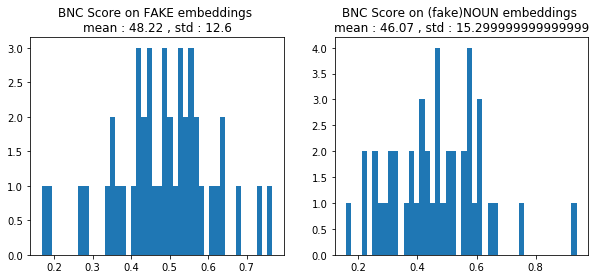

In [21]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(FAKES_BNC_scores,bins=44,density=False)
ax[1].hist(FNOUNS_BNC_scores,bins=44,density=False)
ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
plt.show()

In [22]:
np.round((np.mean(FAKES_BNC_scores),np.std(FAKES_BNC_scores)),4)

array([0.4822, 0.126 ])

In [23]:
np.round((np.mean(FNOUNS_BNC_scores),np.std(FNOUNS_BNC_scores)),4)

array([0.4607, 0.153 ])

In [24]:
counts = nouns_nfs.value_counts(sort=False).sort_index()

valid_parts = []
for part in combinaisons :
    target_0 = 0
    target_1 = 0
    for i, value in enumerate(counts):
        if part[i]:
            target_1 += value
        else:
            target_0 += value
    if np.abs(target_0 - target_1)<=int(max(len(not_fake_samples)*0.09,targets_nfs.sum())):
        valid_parts.append(part)

origin_ind_notfakes = valid_parts.index([0,1,1,1,1,1,0,0,0])
print('original index : ',origin_ind_notfakes)

print('nb of valid partitions : ',len(valid_parts))



original index :  5
nb of valid partitions :  130


In [25]:
parts_to_test = valid_parts[:len(valid_parts)//2]
NFNOUNS_classic_scores = np.empty(len(parts_to_test))
NFNOUNS_BNC_scores = np.empty(len(parts_to_test))

for ind,part in enumerate(parts_to_test):
    part_classes = {listNouns[k]:part[k] for k in range(9)}
    part_targets = pd.Series(data=np.ones(len(not_fake_samples))*-1,index=not_fake_samples.index)
    for i, embd in not_fake_samples.iterrows():
        if part_classes[embd['noun']]==1:
            part_targets[i]=1
    _,NFNOUNS_classic_scores[ind] = classical_accuracy(NearestCentroid(),X_nfs,part_targets,nouns_nfs ,preprocess='kbest',k=10)
    _,NFNOUNS_BNC_scores[ind] = BNC_accuracy(NearestCentroid(),X_nfs,part_targets,nouns_nfs,preprocess='kbest',k=10,debug=ind+1)


Test 65 : BNC for passport ; 88%              

In [26]:
np.max(NFNOUNS_BNC_scores)

0.8861279494406946

In [27]:
high_s_nfnouns = NFNOUNS_BNC_scores[NFNOUNS_BNC_scores>np.mean(NFNOUNS_BNC_scores)]
highest_p_nfnouns = np.flip(np.argsort(NFNOUNS_BNC_scores))[:len(high_s_nfnouns)]
for ind in highest_p_nfnouns:
    if ind == origin_ind_notfakes:
        print(NFNOUNS_BNC_scores[origin_ind_notfakes].round(4) , valid_parts[origin_ind_notfakes], ' baseline (original partition)')
    else:
        print(NFNOUNS_BNC_scores[ind].round(4) , valid_parts[ind], ind)

0.8861 [1, 0, 0, 1, 0, 0, 1, 1, 0] 47
0.8563 [0, 1, 1, 1, 1, 1, 0, 0, 0]  baseline (original partition)
0.7518 [1, 1, 0, 1, 1, 0, 0, 1, 0] 30
0.7329 [1, 0, 0, 1, 1, 0, 0, 1, 0] 29
0.7249 [0, 0, 0, 1, 1, 1, 0, 1, 0] 43
0.7234 [1, 0, 0, 1, 0, 1, 0, 1, 0] 35
0.6781 [0, 1, 1, 0, 1, 1, 0, 1, 0] 42
0.6658 [1, 1, 0, 0, 1, 1, 0, 1, 0] 40
0.6521 [0, 0, 1, 1, 1, 1, 0, 0, 0] 4
0.651 [1, 0, 0, 1, 0, 1, 1, 0, 0] 16
0.6468 [1, 1, 0, 1, 0, 0, 1, 1, 0] 48
0.63 [1, 1, 0, 1, 0, 1, 0, 1, 0] 36
0.6193 [0, 0, 1, 1, 1, 0, 0, 1, 0] 31
0.6182 [1, 0, 1, 0, 1, 0, 0, 1, 0] 27
0.5835 [1, 0, 1, 0, 1, 1, 0, 0, 0] 2
0.5774 [1, 0, 1, 1, 0, 1, 0, 0, 0] 1
0.5764 [0, 1, 0, 1, 1, 1, 0, 1, 0] 44
0.564 [0, 0, 0, 1, 1, 0, 1, 1, 0] 55
0.5566 [0, 0, 1, 1, 0, 1, 0, 1, 0] 37
0.5378 [1, 1, 1, 0, 0, 0, 1, 1, 0] 46
0.5371 [1, 0, 0, 0, 1, 1, 1, 0, 0] 20
0.521 [1, 1, 0, 0, 1, 1, 1, 0, 0] 21
0.5189 [1, 0, 0, 0, 1, 1, 0, 1, 0] 39
0.4935 [0, 1, 1, 1, 0, 1, 0, 1, 0] 38
0.4929 [1, 1, 1, 0, 1, 0, 0, 1, 0] 28
0.4758 [0, 1, 0, 1, 0, 1, 1, 1

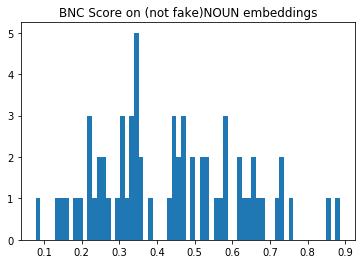

In [28]:
plt.hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False)
plt.title('BNC Score on (not fake)NOUN embeddings')
plt.show()

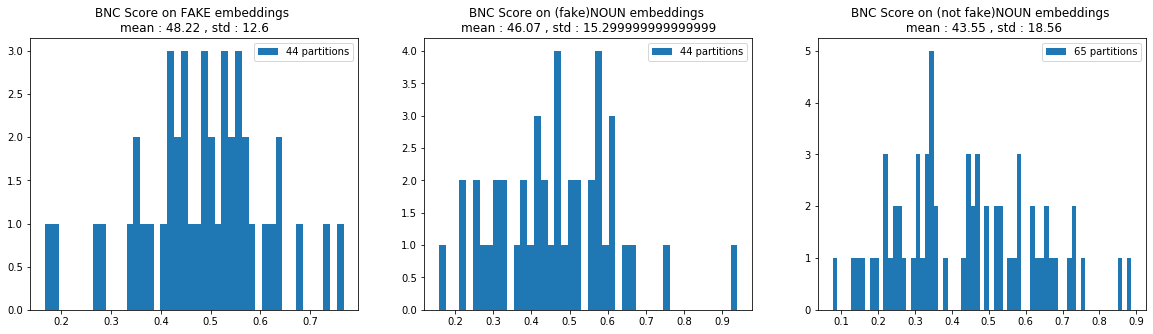

In [29]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist(FAKES_BNC_scores,bins=len(FAKES_BNC_scores),density=False, label='{} partitions'.format(len(FAKES_BNC_scores)))
ax[1].hist(FNOUNS_BNC_scores,bins=len(FNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(FNOUNS_BNC_scores)))
ax[2].hist(NFNOUNS_BNC_scores,bins=len(NFNOUNS_BNC_scores),density=False, label='{} partitions'.format(len(NFNOUNS_BNC_scores)))

ax[0].set_title('BNC Score on FAKE embeddings \nmean : {} , std : {}'.format(np.mean(FAKES_BNC_scores).round(4)*100,np.std(FAKES_BNC_scores).round(3)*100) )
ax[1].set_title('BNC Score on (fake)NOUN embeddings \nmean : {} , std : {}'.format(np.mean(FNOUNS_BNC_scores).round(4)*100,np.std(FNOUNS_BNC_scores).round(4)*100))
ax[2].set_title('BNC Score on (not fake)NOUN embeddings \n mean : {} , std : {}'.format(np.mean(NFNOUNS_BNC_scores).round(4)*100,np.std(NFNOUNS_BNC_scores).round(4)*100))

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('random_scores_BERT_kbest_10_NN.png',dpi=300)
plt.show()

In [ ]:
warnings.filterwarnings('default')